# Table of content: 
Using RMSE as the evaluation metrics. Why? since RSME are sensitive to large errors which mean not missing out on big clients or spending too much to acquire small clients

Naive predictions are used as benchmark for other models.

Statistical models:
- BG/NBD
- Pareto/NBD

Machine Learning models:
- DNN
- Linear Regression


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes

#Let's make this notebook reproducible 
np.random.seed(42)

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Make the default figures a bit bigger
plt.rcParams['figure.figsize'] = (7,4.5) 
plt.rcParams["figure.dpi"] = 140 

sns.set(style="ticks")
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})

In [4]:
df1 = pd.read_csv('./data/olist_orders_dataset.csv')
df2 = pd.read_csv('./data/olist_customers_dataset.csv')
df3 = pd.read_csv('./data/olist_order_payments_dataset.csv')

cols = ['customer_id', 'order_id', 'order_purchase_timestamp']
orders = df1[cols]
orders = orders.set_index('customer_id')
orders.drop_duplicates(inplace=True)

# too few 
cols = ['order_id', 'payment_value']
payment = df3[cols]
payment = payment.set_index('order_id')
payment.drop_duplicates(inplace=True)

cols = ['customer_id', 'customer_unique_id']
customers = df2[cols]
customers = customers.set_index('customer_id')

elog = pd.concat([orders,customers], axis=1, join='inner')
elog.reset_index(inplace=True)

cols = ['customer_unique_id', 'order_purchase_timestamp']
elog = elog[cols]

elog['order_purchase_timestamp'] = pd.to_datetime(elog['order_purchase_timestamp'])
elog['order_date'] = elog.order_purchase_timestamp.dt.date
elog['order_date'] = pd.to_datetime(elog['order_date'])

cols = ['customer_unique_id', 'order_date']
elog = elog[cols]

elog.columns = ['CUSTOMER_ID', 'ORDER_DATE']


elog.info()
display(elog.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CUSTOMER_ID  99441 non-null  object        
 1   ORDER_DATE   99441 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


,CUSTOMER_ID,ORDER_DATE
52263,2d1bf256227e4d22d10ea6c0b81809d7,2018-06-12
46645,12bf514b8d413d8cbe66a2665f4b724c,2018-01-20
37546,83c6df0d47130de38c99cebe96521e8a,2018-06-16
94756,29b186723b197669f69b7d63c3e27c07,2017-08-30
14771,a59129ed35da4c3e3f2a005b4c6582fc,2017-08-10


In [5]:
elog.ORDER_DATE.describe()

count                   99441
unique                    634
top       2017-11-24 00:00:00
freq                     1176
first     2016-09-04 00:00:00
last      2018-10-17 00:00:00
Name: ORDER_DATE, dtype: object

In [6]:
calibration_period_ends = '2018-06-30'

from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(elog, 
                                                   customer_id_col = 'CUSTOMER_ID', 
                                                   datetime_col = 'ORDER_DATE', 
                                                   freq = 'D', #days
                                        calibration_period_end=calibration_period_ends,
                                        observation_period_end='2018-09-28' )

In [7]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CUSTOMER_ID,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,51.0,0.0,90.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,54.0,0.0,90.0
0000f46a3911fa3c0805444483337064,0.0,0.0,477.0,0.0,90.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,261.0,0.0,90.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,228.0,0.0,90.0


In [8]:
from lifetimes import ModifiedBetaGeoFitter

mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'],
       verbose=True)


Optimization terminated successfully.
         Current function value: 0.085065
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43


<lifetimes.ModifiedBetaGeoFitter: fitted with 83748 subjects, a: 0.22, alpha: 218.09, b: 0.12, r: 0.10>

In [9]:
print(mbgnbd)

<lifetimes.ModifiedBetaGeoFitter: fitted with 83748 subjects, a: 0.22, alpha: 218.09, b: 0.12, r: 0.10>


In [10]:
t = 90 # days to predict in the future 
summary_cal_holdout['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      summary_cal_holdout['frequency_cal'], 
                                                                                      summary_cal_holdout['recency_cal'], 
                                                                                      summary_cal_holdout['T_cal'])

summary_cal_holdout['p_alive'] = mbgnbd.conditional_probability_alive(summary_cal_holdout['frequency_cal'], 
                                                                         summary_cal_holdout['recency_cal'], 
                                                                         summary_cal_holdout['T_cal'])
summary_cal_holdout['p_alive'] = np.round(summary_cal_holdout['p_alive'] / summary_cal_holdout['p_alive'].max(), 2)

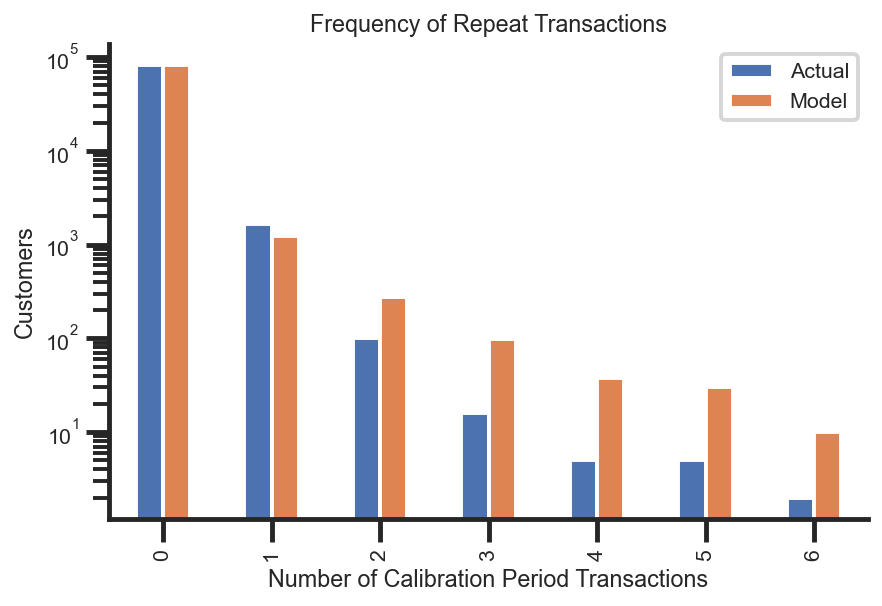

In [11]:
from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbgnbd, max_frequency=7)
ax.set_yscale('log')
sns.despine();

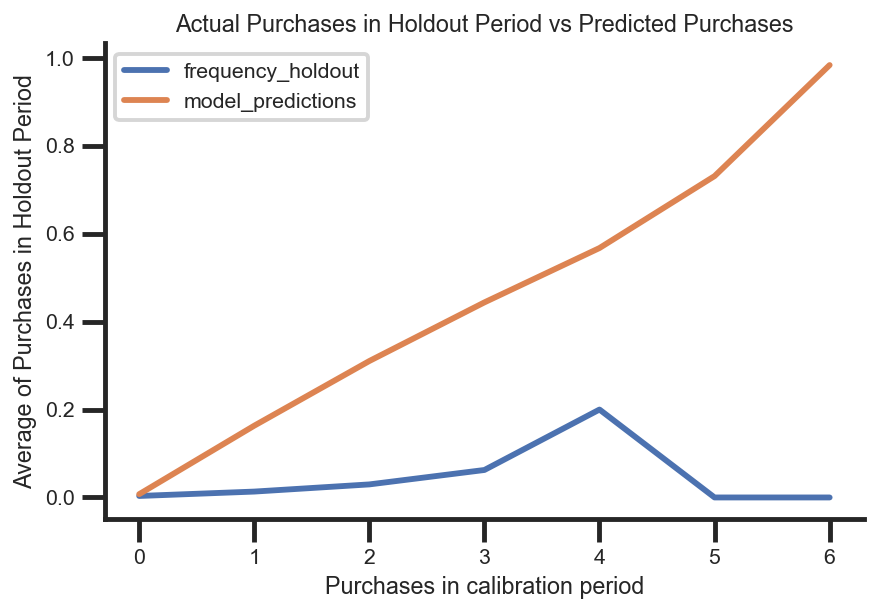

In [12]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(mbgnbd, summary_cal_holdout)
sns.despine();

Probability that customer is alive today is [0.3]


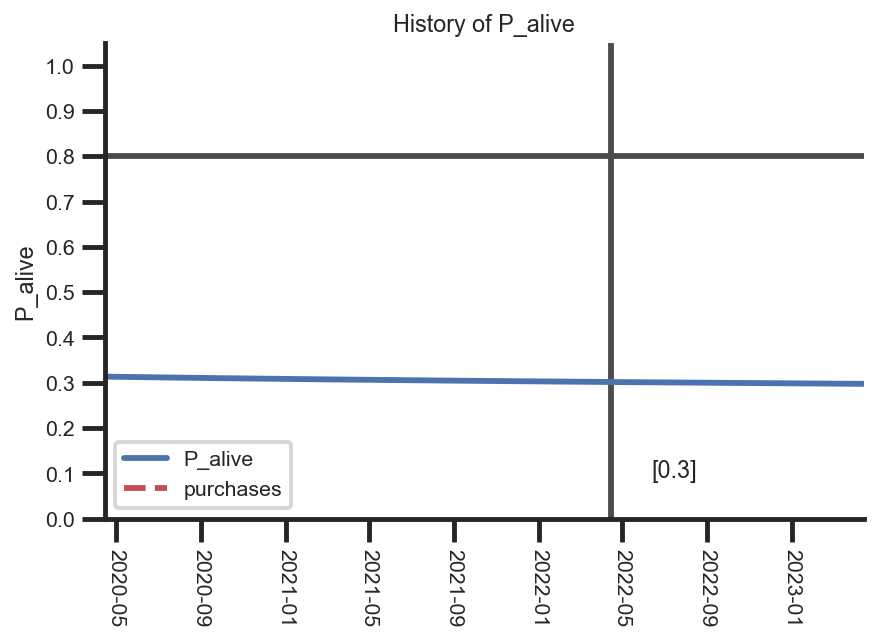

In [13]:
from lifetimes.plotting import plot_history_alive
from datetime import date
from pylab import figure, text, scatter, show

individual = summary_cal_holdout.iloc[4942]

id = individual.name
t = 365*50

today = date.today()
two_year_ago = today.replace(year=today.year - 2)
one_year_from_now = today.replace(year=today.year + 1)

sp_trans = elog.loc[elog['CUSTOMER_ID'] == id]

from lifetimes.utils import calculate_alive_path

t = (today - sp_trans.ORDER_DATE.min().date()).days
p_alive_today = pd.DataFrame(calculate_alive_path(mbgnbd, sp_trans, 'ORDER_DATE', t, freq='D'))[0].tail(1).values
p_alive_today = np.round(p_alive_today[0], 2)
print('Probability that customer is alive today is', p_alive_today)

t = (one_year_from_now - sp_trans.ORDER_DATE.min().date()).days
ax = plot_history_alive(mbgnbd, t, sp_trans, 'ORDER_DATE', start_date=two_year_ago) #, start_date='2016-01-01'
ax.vlines(x=today, ymin=0, ymax=1.05, colors='#4C4C4C')
ax.hlines(y=0.8, xmin=two_year_ago, xmax=one_year_from_now, colors='#4C4C4C')

ax.set_xlim(two_year_ago, one_year_from_now) # sp_trans.ORDER_DATE.min()
ax.set_ylim(0, 1.05)

plt.xticks(rotation=-90)
text(0.75, 0.1, p_alive_today, ha='center', va='center', transform=ax.transAxes)

sns.despine()

In [16]:
elog.columns = ['CUSTOMER_ID', 'date']

In [17]:
from lifetimes.utils import expected_cumulative_transactions

t = (elog.date.max() - elog.date.min()).days
df = expected_cumulative_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t)

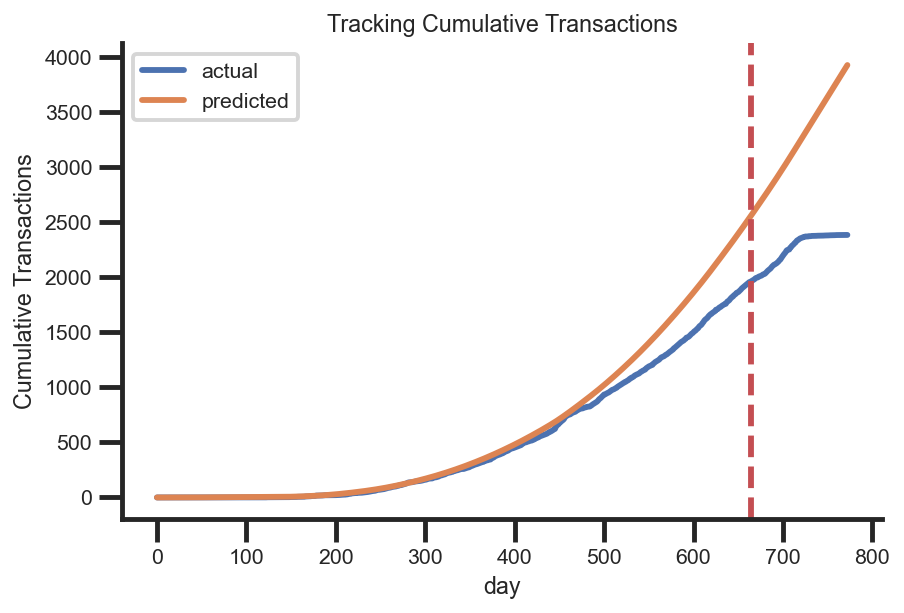

In [18]:
from datetime import datetime

cal = datetime.strptime('2018-06-30', '%Y-%m-%d')

from lifetimes.plotting import plot_cumulative_transactions
t = (elog.date.max() - elog.date.min()).days
t_cal = (cal - elog.date.min()).days
plot_cumulative_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t, t_cal, freq='D')
sns.despine()

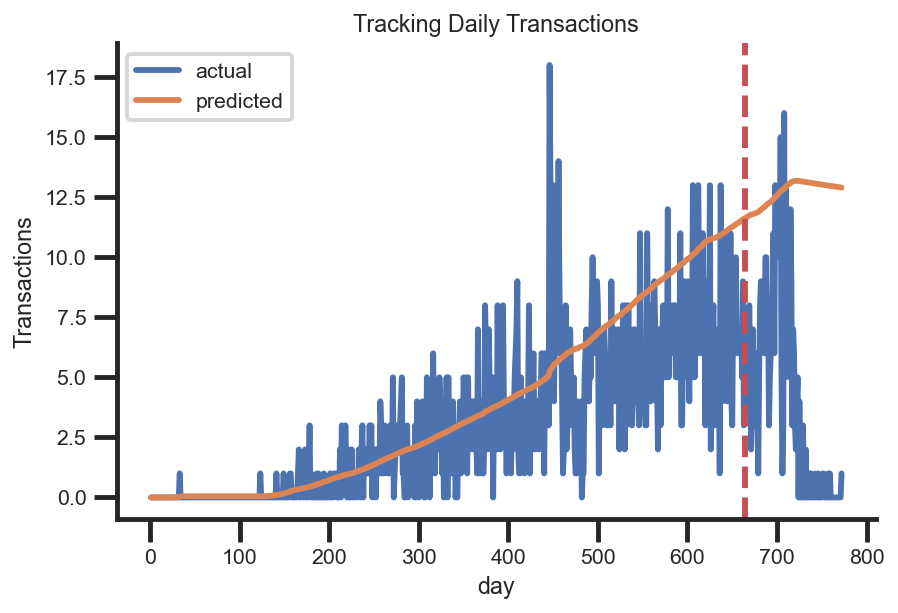

In [19]:
from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t, t_cal, freq='D')
sns.despine()